In [ ]:
# Место для welcome картинки

Содержание:

* [Введение](#Введение)
* [Практическая часть](#Практика)
* [Пара слов о шуме](##Пара)
* [Теперь точно практика](##Теперь)
* [Пробуем начать с нуля](#Пробуем)
* [Небольшое погружение](#Небольшое)


Ссылки:

* [Та самая статья](https://arxiv.org/abs/2006.11239)
* [Курс от huggingface](https://github.com/huggingface/diffusion-models-class)
* [Рассуждения в блоге](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)


#Введение


Мы уже познакомились с некоторыми моделями генеративными моделями. В каждом из семейств моделей (не обязательно служащих для генерации) присутствует своя генеральная идея, концепция, на которой впоследствие строятся гипотезы. Попробуем начать объяснение работы диффузных моделей сразу с такой идеи.

Итак - а что если сделать процесс генерации итеративным?

Получаем примерную схему

*   Шаг 1: Ничего
*   ???
*   Шаг n: Что-то осмысленное

*it ain't much but it's honest work . jpg*

Что такое *Ничего*?
Довольно часто под *ничем* воспринимают простой чёрный (или белый) фон, однако, если подумать, то оба эти состояния характеризуются довольно высокой упорядоченностью
Для нашего повествования за стартовую точку будет взят случайный шум

Что такое *что-то осмысленное*?
Единственный сразу понятный пункт - по старой традиции, сложившейся в процессе курса, осмыслять будем числа из датасета mnist 👀

Дело за малым, понять, что будет в *???*

Сегодня мы поговорим о том, какие ответы на этот вопрос придумало сообщество. Большинство из этих ответов можно найти в статье, посвященной диффузным моделям, а также в курсе от hugging face. Именно на этих материалах был наибольший фокус при подготовке данного ноутбука.

Перейдём к интересному. На данный момент консенсус в следующем: в оставшихся n-2 шагах содержится то, что мы хотим получить в шаге n, но в испорченном виде.



> А так как лейтмотивом наших встреч являются нейронные сети, то дальнейший разговор пойдёт о том, как с их помощью мощью перейти от шага 1 к шагу n



#Практика

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 141210333.55it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111031800.02it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 40407891.21it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5078786.66it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
train_dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

Input shape: torch.Size([6, 1, 28, 28])
Labels: tensor([0, 5, 6, 8, 5, 9])


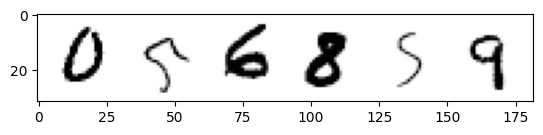

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

##Пара слов о шуме

Нам нужно найти способ, при помощи которого мы бы смогли получать (в нашем случае) испорченное изображение, на котором можно было бы обучиться переходу между состояниями

В статье, которая была упомянута выше, (далее будем называть её DDPM) описан некоторый процесс порчи данных, который по факту определен для любого из наших состояний. Суть процесса заключается в том, что из любого состояния  $x_{t-1}$ мы можем перейти в следующеее чуть более зашумленное $x_t$ при помощи формулы:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


Мы берем вход $x_{t-1}$, а точнее $\sqrt{1 - \beta_t}$ часть входа и добавляем к ней шум, помноженный на $\beta_t$.  $\beta$ определена для каждого t и показывает, насколько сильно будет испорчено изображение. Также благодаря такой конструкции, мы можем напрямую перейти от $x_0$ к любому состоянию $x_t$ игнорируя все промежуточные ступени: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ где $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ и $\alpha_i = 1-\beta_i$<br><br>

То есть переход в любое состояние происходит при помощи переможения коэффициентов

Мы можем посмотреть за тем, как меняется количество сигнала и количество шума в изображении в зависимости от номера шага

In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
coeffs = noise_scheduler.alphas_cumprod.cpu()

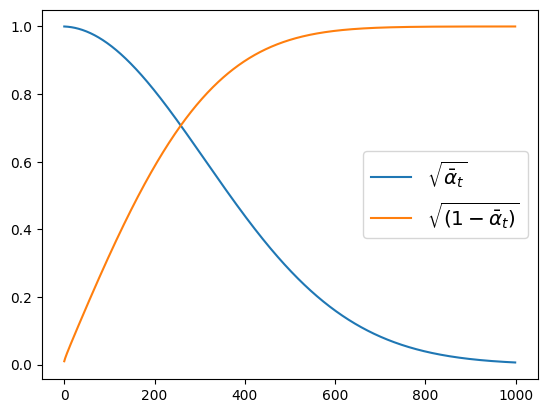

In [ ]:
plt.plot(coeffs ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - coeffs) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Важный момент:

То, как именно задаётся шум и то, какое его количество будет добавляться от состояния к состоянию является принципиальной составляющей обучения в диффузных моделях

Представим, что мы во время обучения тренировали модель на то, чтобы она научилась справляться с уровнем шума, заданным в некоторых промежуточных точках, взятых с графика на оси X выше

Пусть это будут точки c засечек [0, 200, 400, 600, 800, 1000]

В таком случае модель будет при обучении получать на вход изображения вида:

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

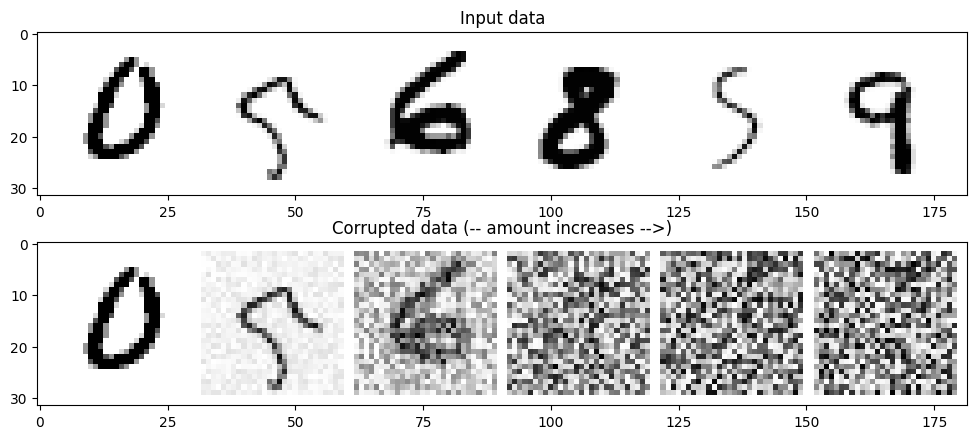

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = 1 - coeffs[[0, 149, 299, 449, 599, 749]] # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

##Теперь точно практика

А теперь от точно выверенных коэффициентов перейдём к чему-то, на чем дальше будет проще продемонстрировать работу сети

Предположим, что шум будет добавляться линейно

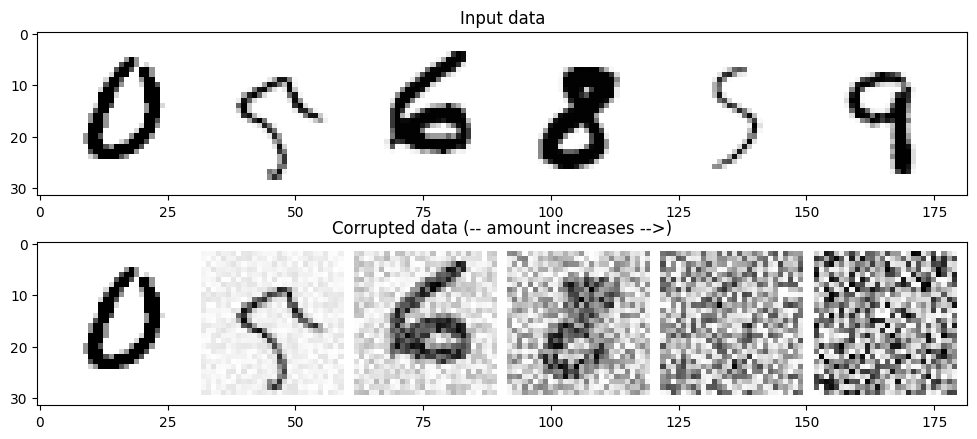

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

Сложно представить, что одна и та же модель одинаково хорошо справится с восстановлением, например цифры 6


Настало время ознакомиться с тем, что же находится внутри

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [ ]:
net = BasicUNet()
x = torch.rand(6, 1, 28, 28)
net(x).shape

torch.Size([6, 1, 28, 28])

In [ ]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.026041
Finished epoch 1. Average loss for this epoch: 0.019908
Finished epoch 2. Average loss for this epoch: 0.018426
Finished epoch 3. Average loss for this epoch: 0.017477
Finished epoch 4. Average loss for this epoch: 0.016846
Finished epoch 5. Average loss for this epoch: 0.016708
Finished epoch 6. Average loss for this epoch: 0.016393
Finished epoch 7. Average loss for this epoch: 0.016183
Finished epoch 8. Average loss for this epoch: 0.016143
Finished epoch 9. Average loss for this epoch: 0.015779


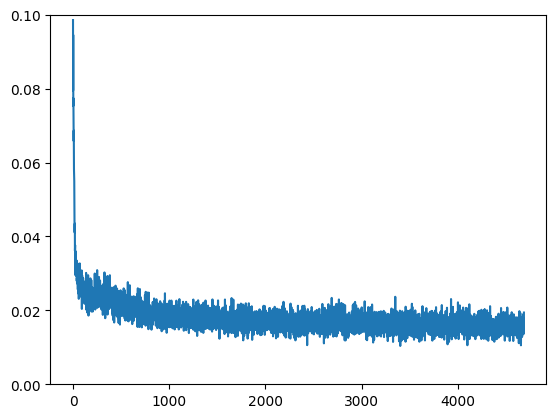

In [ ]:
# Даталоадер
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Сколько раз будет проходиться по выборке
n_epochs = 10

# Объявляем архитектуру
net = BasicUNet()
net.to(device)

# Функция потерь
loss_fn = nn.MSELoss()

# Оптимизатор
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Будем отслеживать прогресс
losses = []

# Цикл обучения
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Получаем данные и пытаемся их испортить
        x = x.to(device) # Помещаем данные на видеокарту
        noise_amount = torch.rand(x.shape[0]).to(device) # Количество шума
        noisy_x = corrupt(x, noise_amount) # Портим наш X

        # Получаем предсказание
        pred = net(noisy_x)

        # Вычисляем функцию потерь
        loss = loss_fn(pred, x) # Насколько наши данные близки к первоначальному X?

        # Алгоритм обратного распространения ошибки и обновление коэфициентов
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Записываем значение функции потерь
        losses.append(loss.item())

    # Выводим среднее значение функции потерь
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Выводим график
plt.plot(losses)
plt.ylim(0, 0.1);

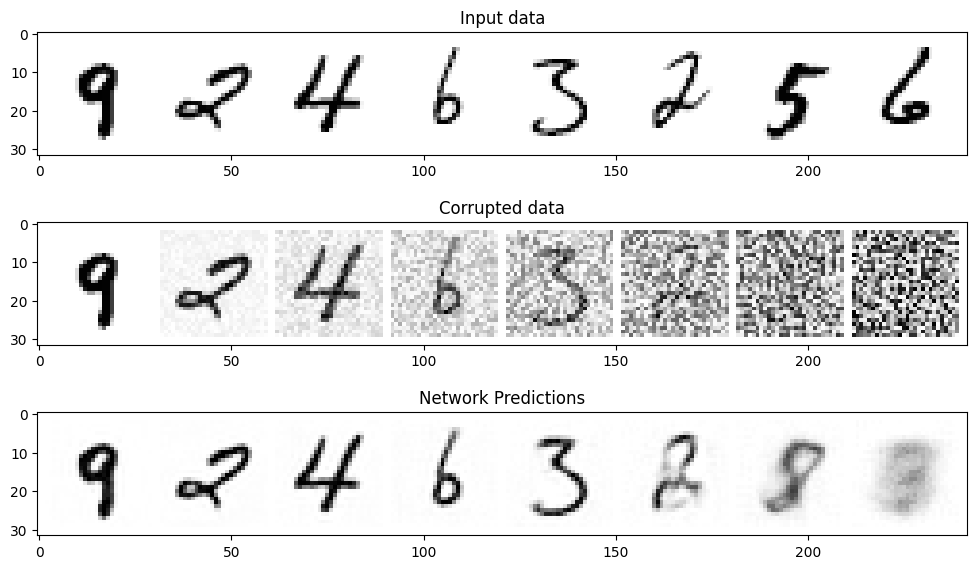

In [ ]:
#Выводим предсказания по зашумленным данным

x, y = next(iter(train_dataloader))
x = x[:8] # Берем первые 8 для простоты визуализации

# Зашумляем данные
amount = torch.linspace(0, 1, x.shape[0]) # Слева направо -> уровень шума растет
noised_x = corrupt(x, amount)

# Получаем предсказания
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

#Попробуем начать с нуля

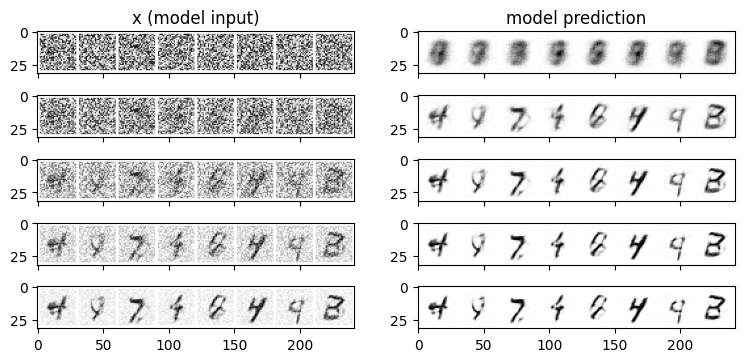

In [ ]:
#Разбиваем процесс на 5 шагов и продвигаемся на 1/5 к цели за раз:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Начинаем со случайного шума
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # Убираем градиенты на время использования модели
        pred = net(x) # Пробуем сделать предсказание
    pred_output_history.append(pred.detach().cpu()) # Сохраняем промежуточный результат для визуализации
    mix_factor = 1/(n_steps - i) # Как быстро мы приближаемся к цели
    x = x*(1-mix_factor) + pred*mix_factor # Делаем шаг
    step_history.append(x.detach().cpu()) # Сохраняем результат для визуализации

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

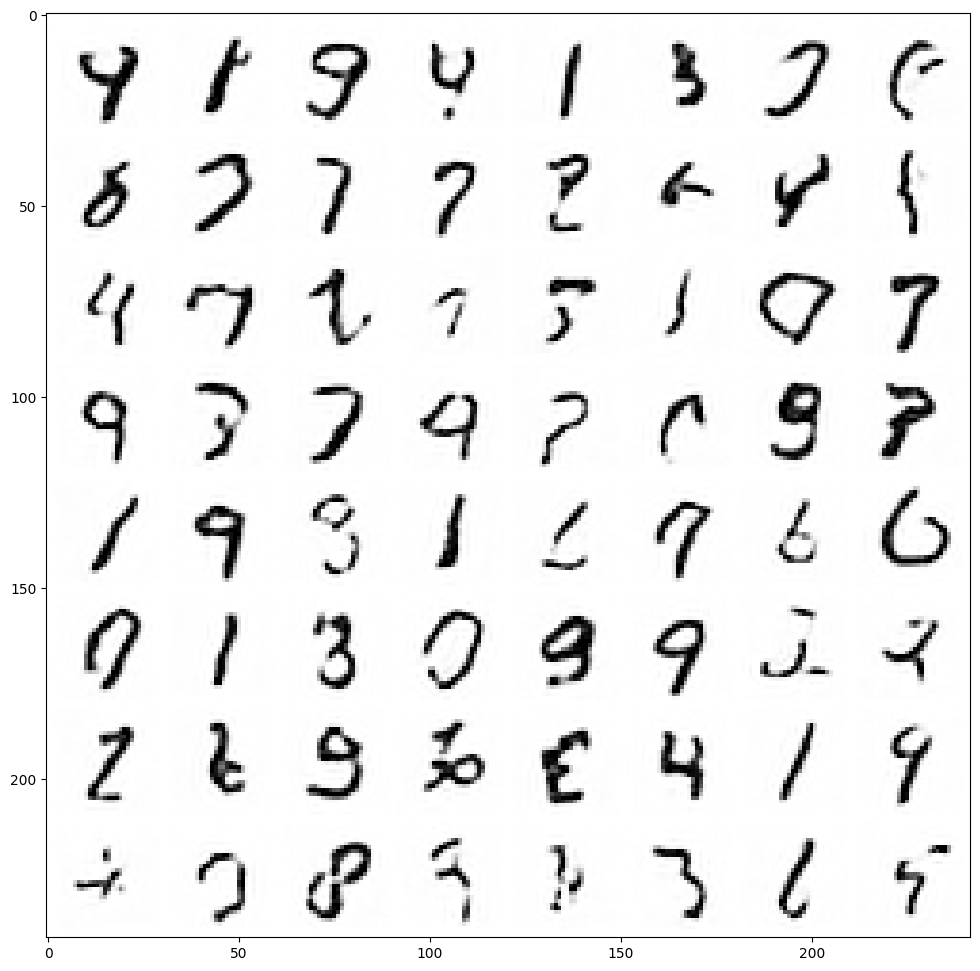

In [ ]:
# Что если сделать больше шагов?
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Постепенно уменьшаем уровень шума
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

#Небольшое погружение

Finished epoch 0. Average loss for this epoch: 0.020006
Finished epoch 1. Average loss for this epoch: 0.012709
Finished epoch 2. Average loss for this epoch: 0.011608
Finished epoch 3. Average loss for this epoch: 0.011151
Finished epoch 4. Average loss for this epoch: 0.010740
Finished epoch 5. Average loss for this epoch: 0.010621
Finished epoch 6. Average loss for this epoch: 0.010307
Finished epoch 7. Average loss for this epoch: 0.010071
Finished epoch 8. Average loss for this epoch: 0.010143
Finished epoch 9. Average loss for this epoch: 0.009900


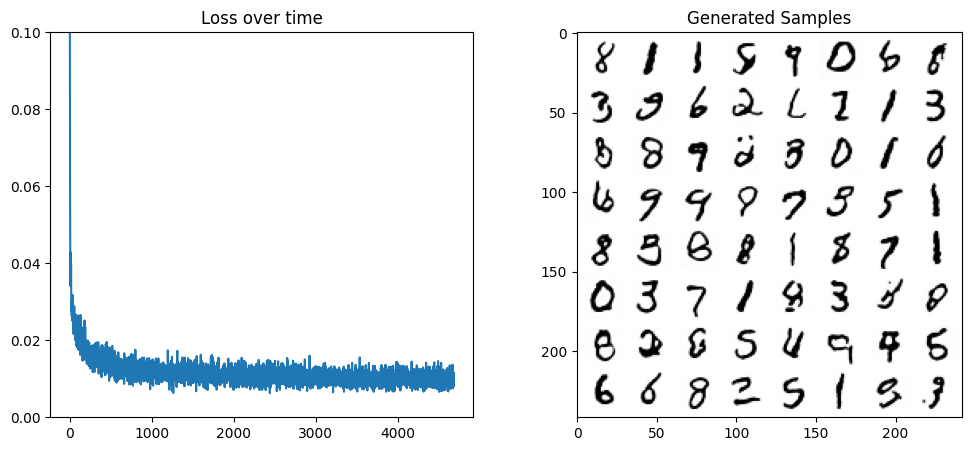

In [ ]:
# Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');